<a href="https://colab.research.google.com/github/fodothing/HieGAT/blob/main/MyModel_Mirror.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prerequisites

This is a AB testing.

In [1]:
# Import Libraries
import os
import re
import time
import numpy as np
import random
import pandas as pd
import torch as th
from sklearn.model_selection import train_test_split  # for train and dev set split
from torch.nn import functional as F
import matplotlib.pyplot as plt
from datetime import datetime
import word2vec
import dgl

import nltk
'''
nltk.download('punkt')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
'''
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from dgl.nn import GATConv


# Set Random Seed
SEED = 42
th.manual_seed(SEED)
th.cuda.manual_seed(SEED)
random.seed(SEED)

# Set Common Path
COMMON_PATH = "/Users/hshuaifile"

D:\ProgramData\Anaconda3\envs\hshuai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\ProgramData\Anaconda3\envs\hshuai\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#Dataset Preprocessing

##Clean Text

In [2]:
# Clean Data
def Clean_Text(text):
  re_url = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  re_email = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|" \
  (?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:\
  (?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}\
  (?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')

  text = text.lower()
  text = text.strip()
  text = re.sub(re_url, '', text)
  text = re.sub(re_email, '', text)
  text = re.sub(r"\s{2,}", " ", text)
  
  
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ll", " will", text)

  text = re.sub(r"[^A-Za-z().?!\'\`]", " ", text)
  text = re.sub(r"\(", "\( ", text)
  text = re.sub(r"\)", "\) ", text)
  text = re.sub(r"\'", "", text)
  text = re.sub(r'`', '', text)

  return text

def Clean_and_Save(path, dataset_name):
  NAME = dataset_name
  if NAME not in ['20ng', 'r8', 'r52', 'oh', 'mr']:
    raise ValueError('The dataset is not support')
  raw_x = []
  with open(os.path.join(path, NAME+'.txt'), encoding='ISO-8859-1') as f:
    data = f.readlines()
    print(f'{NAME}, Total sample: {len(data)}')
  with open(os.path.join(path, NAME+'_mapping.txt'), encoding='ISO-8859-1') as f:  # latin1
    map = f.readlines()
    print(f'{NAME}, Total mapping: {len(map)}')
  if len(map) != len(data):
    raise Exception('Map size not equal to data')
  
  # Clean Sample and Save
  tra_x, tra_y = [], []
  tes_x, tes_y = [], []
  for i in range(len(map)):
    cle_x = Clean_Text(data[i]).strip()  # X
    lab = map[i].split('\t')  # y
    if lab[len(lab)-2] in ['20news-bydate-test', 'test']:
      tes_x.append(cle_x)
      tes_y.append(re.sub(r'\n', '', lab[len(lab)-1]))
    elif lab[len(lab)-2] in ['20news-bydate-train', 'train', 'training']:
      tra_x.append(cle_x)
      tra_y.append(re.sub(r'\n', '', lab[len(lab)-1]))
  if len(tes_y)!=len(tes_x) or len(tra_x)!=len(tra_y):
    raise Exception('Numbef of x is not equal y')
  
  print(f'Total train: {len(tra_x)}')
  print(f'Total test: {len(tes_x)}')

  # Save to csv
  df_tra = pd.DataFrame({'tra_y': tra_y, 'tra_x': tra_x})
  df_tes = pd.DataFrame({'tes_y': tes_y, 'tes_x': tes_x})
  # Remove the csv header
  df_tra.columns = range(df_tra.shape[1])
  df_tes.columns = range(df_tes.shape[1])
  df_tra.to_csv(f'{COMMON_PATH}/TextLevelGNN/data/{NAME}-stemmed.txt', index=False, sep='\t',header=None)
  df_tes.to_csv(f'{COMMON_PATH}/TextLevelGNN/data/{NAME}-test-stemmed.txt', index=False, sep='\t',header=None)

path = f'{COMMON_PATH}/TextLevelGNN/data/'
for name in ['20ng', 'r8', 'r52', 'oh', 'mr']:
  t0 = time.time()
  #if name not in ["oh"]: continue  # Check for specific dataset 
  Clean_and_Save(path, name)
  print(f'Time: {time.time() - t0:.4f}s')
  print('='*50)


20ng, Total sample: 18846
20ng, Total mapping: 18846
Total train: 11314
Total test: 7532
Time: 3.7655s
r8, Total sample: 7674
r8, Total mapping: 7674
Total train: 5485
Total test: 2189
Time: 0.6013s
r52, Total sample: 9100
r52, Total mapping: 9100
Total train: 6532
Total test: 2568
Time: 0.7787s
oh, Total sample: 7400
oh, Total mapping: 7400
Total train: 3357
Total test: 4043
Time: 1.6914s
mr, Total sample: 10662
mr, Total mapping: 10662
Total train: 7108
Total test: 3554
Time: 0.3410s


##Convert to Token

In [3]:
# Build Vocab on All Train Sample
def BuildVocab(TrainSample, min_count):
  freq = {}
  for x in TrainSample:
    for t in word_tokenize(x):
      if t not in freq:
        freq[t] = 0
      else:
        freq[t] += 1
  del_key = []
  for i in freq:
    if freq[i]<min_count:
      del_key.append(i)
  
  for i in del_key:freq.pop(i)

  vocab_id = {}
  for i, key in enumerate(freq): vocab_id[key] = i
  vocab_id["unk_"] = i+1  # Unknow word index (OOV)

  print(f'vocab_size={len(vocab_id)}, min_count={min_count}')
  print('='*50)

  return vocab_id


# Convert Word to ID Number
def X2Id(X, vocab):
  ids = []
  for w in word_tokenize(X):
    if w in vocab:
      ids.append(vocab[w])
    else:
      ids.append(vocab["unk_"])
  
  return ids


# Convert String Tex to Token Number
def Text2Token(vocab, text_list):
  temp = []
  for text in text_list:
    temp.append(X2Id(text, vocab))
  
  return temp


# Split Train and Dev Set
def Tra_Dev_Set(all_train_text, all_train_label, dataset_name):
  if dataset_name=="r52":
    train_x, dev_x, train_y, dev_y = train_test_split(all_train_text, all_train_label, test_size=0.06, shuffle=True, random_state=42)
  else:
    train_x, dev_x, train_y, dev_y = train_test_split(all_train_text, all_train_label, \
                                                      test_size=0.1, shuffle=True, random_state=42, stratify=all_train_label)

  return train_x, dev_x, train_y, dev_y


# Shuffle All Train Sample, Split and Token
def MyDataset(dataset_name):
  NAME = dataset_name
  if NAME not in ['20ng', 'r8', 'r52', 'oh', 'mr']:
    raise ValueError('The dataset is not support')
  
  frame = {"all_train_text":[], "all_train_label":[], "test_text":[], "test_label":[]}
  PATH = f'{COMMON_PATH}/TextLevelGNN/data/'
  for t1,t2,t3 in [("-stemmed.txt", "all_train_text", "all_train_label"),
                      ("-test-stemmed.txt", "test_text", "test_label")]:
    with open(os.path.join(PATH, NAME+t1), 'r') as f:
      data = f.readlines()
      for line in data:
        line = line.strip()
        temp = line.split('\t')
        frame[t2].append(temp[1])  # X
        frame[t3].append(temp[0])  # y
    
  train_text, dev_text, train_label, dev_label = Tra_Dev_Set(frame["all_train_text"], frame["all_train_label"], NAME)
  test_text, test_label = frame["test_text"], frame["test_label"]
  
  num_class = list(set(train_label))  # len(num_class)
  label2idx = {label: idx for idx, label in enumerate(num_class)}
  print(f'Dataset={NAME}, Num_class={len(num_class)}, labels={label2idx}')
  print(f'All_train={len(frame["all_train_text"])}, Train_size={len(train_text)}, Dev_size={len(dev_text)}, Test_size={len(test_text)}')

  min_count = {'20ng':2, 'r8':2, 'r52':2, 'oh':1, 'mr':1}  # Min count for building vocab
  vocab = BuildVocab(train_text, min_count[NAME])
  train_text_tok = Text2Token(vocab, train_text)
  dev_text_tok = Text2Token(vocab, dev_text)
  test_text_tok = Text2Token(vocab, test_text)

  train_label_tok = [label2idx[t] for t in train_label]
  dev_label_tok = [label2idx[t] for t in dev_label]
  test_label_tok = [label2idx[t] for t in test_label]

  
  return train_text_tok,  train_label_tok, dev_text_tok, dev_label_tok, \
          test_text_tok, test_label_tok, len(num_class), vocab

# Model Architecture

In [11]:
# Model Architecture
class GATLayer(th.nn.Module):
  def __init__(self, in_dim, hidden_dim):
    super(GATLayer, self).__init__()
    self.feat_drop = 0.2
    self.attn_drop = 0.2
    self.gat_layer = GATConv(in_dim, hidden_dim, 2, self.feat_drop, self.attn_drop, activation=F.elu)

  def forward(self, g, inputs):
    inputs = self.gat_layer(g, inputs)
    h = inputs.mean(1)
    
    return h


class MyModel(th.nn.Module):
  def __init__(self, vocab, in_dim, hidden_dim, num_class, device):
    super(MyModel, self).__init__()
    self.lgram = 5
    self.rgram = 5
    self.vocab = vocab
    self.num_class = num_class
    self.device = device
    self.max_length = 300
    self.vocab_size = len(vocab)
    self.node_hidden = th.nn.Embedding(self.vocab_size, in_dim)
    self.node_hidden.weight.data.copy_(th.tensor(self.Load_w2v(f'{COMMON_PATH}/TextLevelGNN/data/glove.6B.300d.w2vformat.txt')))
    self.node_hidden.weight.requires_grad = True
    self.gat1 = GATLayer(in_dim, hidden_dim)
    self.gat2 = GATLayer(in_dim, hidden_dim)
    self.lin1 = th.nn.Linear(hidden_dim*3, num_class)
    self.lin2 = th.nn.Linear(hidden_dim*3, num_class)

  
  def Load_w2v(self, path):
    w2v = word2vec.load(path)
    embedding_matrix = []
    unk_d = len(w2v['the'])  # Unknow eord dimension
    for word in self.vocab:
      try:
        embedding_matrix.append(w2v[word])
      except KeyError:
        embedding_matrix.append(np.zeros(unk_d))

    return np.array(embedding_matrix)
  
  def MyScatter(self, mat, n, region=2, stride=1, merge="mean"):
    m = []
    for i in range(0, n, stride):
      if i+region<n:
        m.append(th.mean(mat[i:i+region], dim=-2).unsqueeze(0))
      else:
        m.append(th.mean(mat[i:], dim=-2).unsqueeze(0))
    
    return th.cat(m, dim=0)

  def AddEdgeCNN(self, n):  # For Pooling graph
    edges = []
    for i in range(n):
      for j in range(max(0, i-self.lgram), min(i + self.rgram + 1, n)):  # Directed graph
        edges.append([i, j])
    
    return edges


  def BuildGraphCNN(self, sample):
    t = len(sample)
    if t == 0: raise Exception('sample length is equal 0')
    if t > self.max_length: sample = sample[:self.max_length]
    n = len(sample)
    u, v = zip(*self.AddEdgeCNN(n))
    g = dgl.graph((u, v), num_nodes=n).to(self.device)
    sample_index = th.tensor(sample).to(self.device)
    g.ndata['h'] =  self.node_hidden(sample_index)

    h1 = self.MyScatter(g.ndata['h'], n, 2, 2)
    h2 = self.MyScatter(g.ndata['h'], n, 4, 2)
    h3 = self.MyScatter(g.ndata['h'], n, 8, 2)
    u1, v1 = zip(*self.AddEdgeCNN(len(h1)))
    u2, v2 = zip(*self.AddEdgeCNN(len(h2)))
    u3, v3 = zip(*self.AddEdgeCNN(len(h3)))

    g1 = dgl.graph((u1, v1), num_nodes=len(h1)).to(self.device)
    g2 = dgl.graph((u2, v2), num_nodes=len(h2)).to(self.device)
    g3 = dgl.graph((u3, v3), num_nodes=len(h3)).to(self.device)
    g1.ndata['h'] = h1
    g2.ndata['h'] = h2
    g3.ndata['h'] = h3

    return g, g1, g2, g3
  
  def BatchCat(self, g, gatlayer):
    batch_g = dgl.batch(g)
    batch_g.ndata['h'] = gatlayer(batch_g, batch_g.ndata['h']) # Update node embedding
    out1 = dgl.mean_nodes(batch_g, feat='h')
    out2 = dgl.max_nodes(batch_g, feat='h')
    out3 = dgl.sum_nodes(batch_g, feat="h")
    output = th.cat([out1, out2, out3], dim=1)

    return output

  def forward(self, sample):
    g, g1, g2, g3 = [], [], [], []

    for t in sample:
      tg, tg1, tg2, tg3 = self.BuildGraphCNN(t)  # Temp graph
      g.append(tg)  # 0.08s
      g1.append(tg1)
      g2.append(tg2)
      g3.append(tg3)
    o = self.BatchCat(g, self.gat1)  # Output
    o1 = self.BatchCat(g1, self.gat1)
    o2 = self.BatchCat(g2, self.gat1)
    o3 = self.BatchCat(g2, self.gat1)
    
    output = self.lin1(o+o1+o2+o3)
    score = F.log_softmax(output, dim=-1)  # Score on each class

    return score


#Model Train and Test

In [12]:
# Train Function
def Train(model, epoch, train_X, train_y, dev_X, dev_y, device, dataset_name):
  optimizer = th.optim.AdamW(model.parameters(), weight_decay=1e-3, lr=5e-4)
  PATIENCE = 6  # Patience on dev set to stop training
  no_improve = 0
  best_acc = 0.0
  all_loss = []
  all_dev_acc = []
  all_epo = []
  for e in range(epoch):
    improved = ''
    model.train()
    for batch_X, batch_y in zip(train_X, train_y):
      batch_y = batch_y.to(device)
      optimizer.zero_grad()  # Clear gradient
      score = model(batch_X)
      loss = F.nll_loss(score, batch_y)
      loss.backward()  # Derive gradient
      optimizer.step()  # Update gradient
    #train_acc = Dev(model, train_X, train_y, device)
    dev_acc = Dev(model, dev_X, dev_y, device)
    if dev_acc>best_acc:
      best_acc = dev_acc
      no_improve = 0
      improved = '*'
      th.save(model, f'{COMMON_PATH}/TextLevelGNN/model/MyModel.pkl')
    else: 
      no_improve+=1
    all_loss.append(loss.item())
    all_dev_acc.append(dev_acc.cpu().numpy())
    all_epo.append(e)
    if e%5 == 0:
      print(f'Epoch={e+1}/{epoch}, Train_loss={loss.item():.4f}, Dev_acc={dev_acc:.4f}, {improved}')
    if no_improve>=PATIENCE:
      print(f'No improvement on dev set, early stopping.')
      break
  now_time = datetime.now()
  t = re.sub(r' |:|\.', '-', str(now_time))
  df = pd.DataFrame({"epoch":all_epo, "loss":all_loss, "dev_acc":all_dev_acc})
  df.to_csv(f"{COMMON_PATH}/TextLevelGNN/model/loss_acc/{dataset_name}-loss-{t}.csv", index=False)


# Dev Function
def Dev(model, X, y, device):
  model.eval()
  total = 0.0
  correct = 0.0
  for batch_X, batch_y in zip(X, y):
    batch_y = batch_y.to(device)

    with th.no_grad():
      score = model(batch_X)
      pred = th.argmax(score, dim=1)
      correct += th.sum(pred==batch_y)
      total += len(batch_y)

  return th.div(correct, total)


# Test Function (Same as Dev)
def Test(model, X, y, device):
  model.eval()
  total = 0.0
  correct = 0.0
  for batch_X, batch_y in zip(X, y):
    batch_y = batch_y.to(device)

    with th.no_grad():
      score = model(batch_X)
      pred = th.argmax(score, dim=1)
      correct += th.sum(pred==batch_y)
      total += len(batch_y)

  return th.div(correct, total)


#Run Experiment

In [ ]:
# Batch the Dataset
def Batch(X, y, batch_size=128, shuffle=False):
  data = [(X[i], y[i]) for i in range(len(y))]
  if shuffle:
    random.shuffle(data)
    X = [t for t,_ in data]  # Shuffled X
    y = [t for _,t in data]  # Shuffled y 
  batched_X = [X[i:i+batch_size] for i in range(0, len(data), batch_size)]
  batched_y = [th.tensor(y[i:i+batch_size]) for i in range(0, len(data), batch_size)]
  
  return batched_X, batched_y


# Save Experiment Result (Acuuracy and Running Time)
def SaveResult(acc, time, dataset_name):
  df1 = pd.DataFrame({"Acc": acc})
  df2 = pd.DataFrame({"Time": time})
  df1.to_csv(f'{COMMON_PATH}/TextLevelGNN/model/Acc-{dataset_name}.csv', index=False)
  df2.to_csv(f'{COMMON_PATH}/TextLevelGNN/model/Time-{dataset_name}.csv', index=False)


def MeanAcc(dataset_name):
  acc_mean = []
  acc_std = []
  for name in dataset_name:
    df = pd.read_csv(f'{COMMON_PATH}/TextLevelGNN/model/Acc-{name}.csv')
    acc = df["Acc"].iloc[0:]
    acc_mean.append(np.mean(acc))
    acc_std.append(np.std(acc))

  return acc_mean, acc_std


def MeanTime(dataset_name):
  mean_time = []
  for name in dataset_name:
    df = pd.read_csv(f'{COMMON_PATH}/TextLevelGNN/model/Time-{name}.csv')
    time = df["Time"].iloc[0:]
    mean_time.append(np.mean(time))
    
  return mean_time


# Save Average Result for All Dataset
def SaveTotalResult(dataset):
  my_acc, my_std = MeanAcc(dataset)
  my_time = MeanTime(dataset)
  print(f"acc_mean={my_acc}")
  print(f"acc_std={my_std}")
  print(f"time_mean(m)={my_time}")
  now_time = datetime.now()
  t = re.sub(r' |:|\.', '-', str(now_time))
  df = pd.DataFrame({"dataset":dataset, "acc_mean":my_acc, "acc_std":my_std, "time_mean(m)":my_time})
  df.to_csv(f'{COMMON_PATH}/TextLevelGNN/model/Total-result{t}.csv', index=False)


# Set Training Device
DEVICE = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
if th.cuda.is_available():
  print(f'device: {DEVICE}')
  print(f'name: {th.cuda.get_device_name(0)}')
  print(f'='*50)

# Set Constant
shuffle_time = 1
run_time = 5  # Run n times to get average
epoch=100
dataset = ['r8',  'r52', 'oh', 'mr', '20ng']

#remove old  training loss data before new run
!rm /Users/hshuaifile/TextLevelGNN/model/loss_acc/*

print("="*50)
all_time_start = time.time()
for NAME in dataset:
  #if NAME not in ["mr", "oh"]: continue  # Check for specific dataset
  all_acc = []
  consume_time = []
  for s in range(shuffle_time):
    train_text_tok, train_label_tok, dev_text_tok, dev_label_tok, test_text_tok, test_label_tok, num_class, vocab = MyDataset(NAME)
    dev_X, dev_y = Batch(dev_text_tok, dev_label_tok)
    test_X, test_y = Batch(test_text_tok, test_label_tok)
    for i in range(run_time):
      train_X, train_y = Batch(train_text_tok, train_label_tok, shuffle=True)  # Shuffle train dataset run n times to get average
      t0 = time.time()
      row_model = MyModel(vocab, 300, 300, num_class, DEVICE)
      row_model.to(DEVICE)
      Train(row_model, epoch, train_X, train_y, dev_X, dev_y, DEVICE, NAME)
      trained_model = th.load(f'{COMMON_PATH}/TextLevelGNN/model/MyModel.pkl', map_location=DEVICE)
      acc = Test(trained_model, test_X, test_y, DEVICE).cpu().numpy()
      print(f'{NAME}, ShuffleTime={s+1}/{shuffle_time}, RunTime={i+1}/{run_time}, Test_acc={acc:.4f}, Ave_Epoch_Time={(time.time()-t0)/epoch:.1f}s, All_Epoch_Time={(time.time()-t0)/60:.1f}m')
      all_acc.append(acc)
      consume_time.append((time.time()-t0)/60)
      print("="*50)
    print("="*100)
  SaveResult(all_acc, consume_time, NAME)

SaveTotalResult(dataset)
print("="*50)
print(f"All Time Use: {(time.time()-all_time_start)/3600:.1f}h")

device: cuda:0
name: NVIDIA GeForce RTX 3090
Dataset=r8, Num_class=8, labels={'interest': 0, 'ship': 1, 'money-fx': 2, 'crude': 3, 'trade': 4, 'acq': 5, 'grain': 6, 'earn': 7}
All_train=5485, Train_size=4936, Dev_size=549, Test_size=2189
vocab_size=7051, min_count=2
Epoch=1/100, Train_loss=0.2589, Dev_acc=0.9381, *


# Result Plot

## Acc Plot

Model performance on test set.

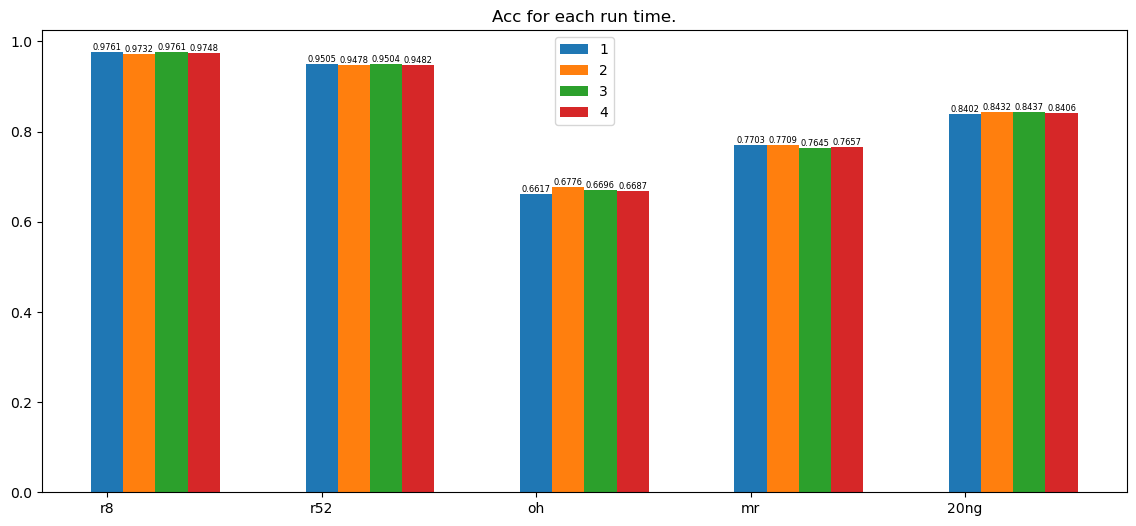

In [ ]:
def ShowAllResult():
  all_acc_mean, all_acc_time, all_acc_std = [], [], []
  all_file = os.listdir(f"{COMMON_PATH}/TextLevelGNN/model/")
  for t in all_file:
    if t.startswith("Total-result"):
      df = pd.read_csv(f"{COMMON_PATH}/TextLevelGNN/model/{t}")
      all_acc_mean.append(df["acc_mean"])
      all_acc_time.append(df["time_mean(m)"])
      all_acc_std.append(df["acc_std"])
      #break
  
  return all_acc_mean, all_acc_std, all_acc_time

dataset = ['r8',  'r52', 'oh', 'mr', '20ng']     
all_acc_mean, all_acc_std, all_acc_time = ShowAllResult()

fig = plt.figure(figsize=(14,6),dpi=100)

ax1 = fig.add_subplot(111)
x_length = np.arange(len(dataset))
bar_width = 0.15
for i in range(len(all_acc_mean)):
  x = x_length+i*bar_width
  y = all_acc_mean[i]
  ax1.bar(x, y, width=bar_width, label=f'{i+1}')
  for a,b in zip(x, y):
    ax1.text(a, b, round(b,4), ha="center", va="bottom", fontsize=6)
plt.xticks(x_length, dataset)
plt.title("Acc for each run time.")

ax1.legend()
plt.show()

## Time, Std

Running time, standard variances of accuracy on test set.

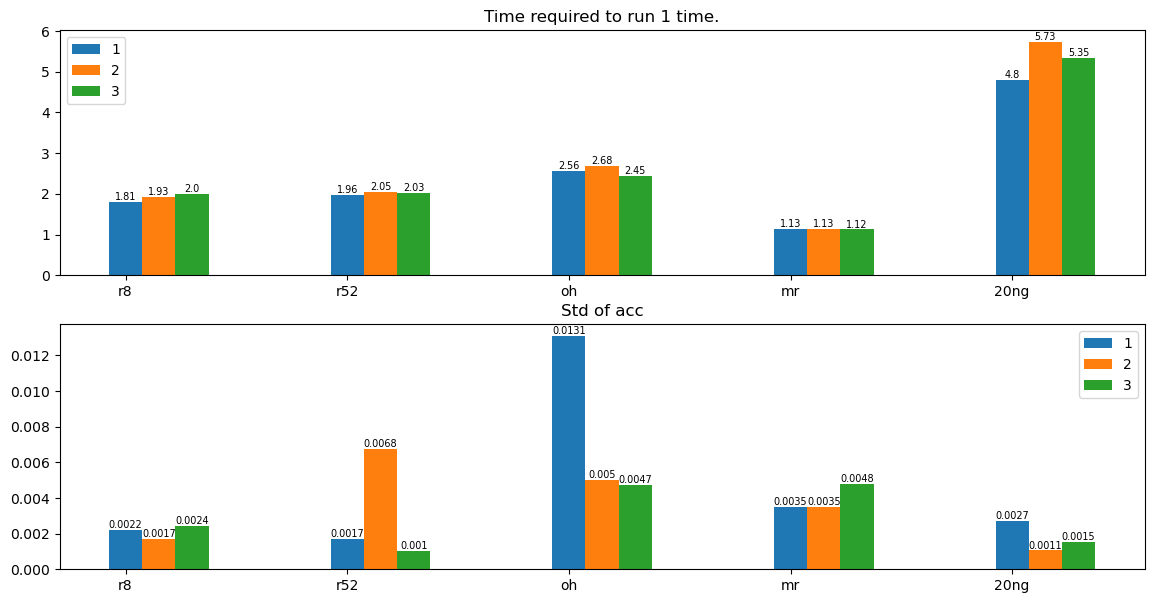

In [ ]:
fig = plt.figure(figsize=(14,7), dpi=100)

ax1 = fig.add_subplot(211)
x_length = np.arange(len(dataset))
bar_width = 0.15
for i in range(len(all_acc_time)):
  x = x_length+i*bar_width
  y = all_acc_time[i]
  ax1.bar(x, y, width=bar_width, label=f'{i+1}')
  for a,b in zip(x, y):
    ax1.text(a, b, round(b,2), ha="center", va="bottom", fontsize=7)
plt.xticks(x_length, dataset)
plt.title("Time required to run 1 time.")
ax1.legend()

ax2 = fig.add_subplot(212)
x_length = np.arange(len(dataset))
bar_width = 0.15
for i in range(len(all_acc_std)):
  x = x_length+i*bar_width
  y = all_acc_std[i]
  ax2.bar(x, y, width=bar_width, label=f'{i+1}')
  for a,b in zip(x, y):
    ax2.text(a, b, round(b,4), ha="center", va="bottom", fontsize=7)
plt.xticks(x_length, dataset)
plt.title("Std of acc")
ax2.legend()

plt.show()

## Loss, Dev Acc

Training loss, accuracy on dev set.

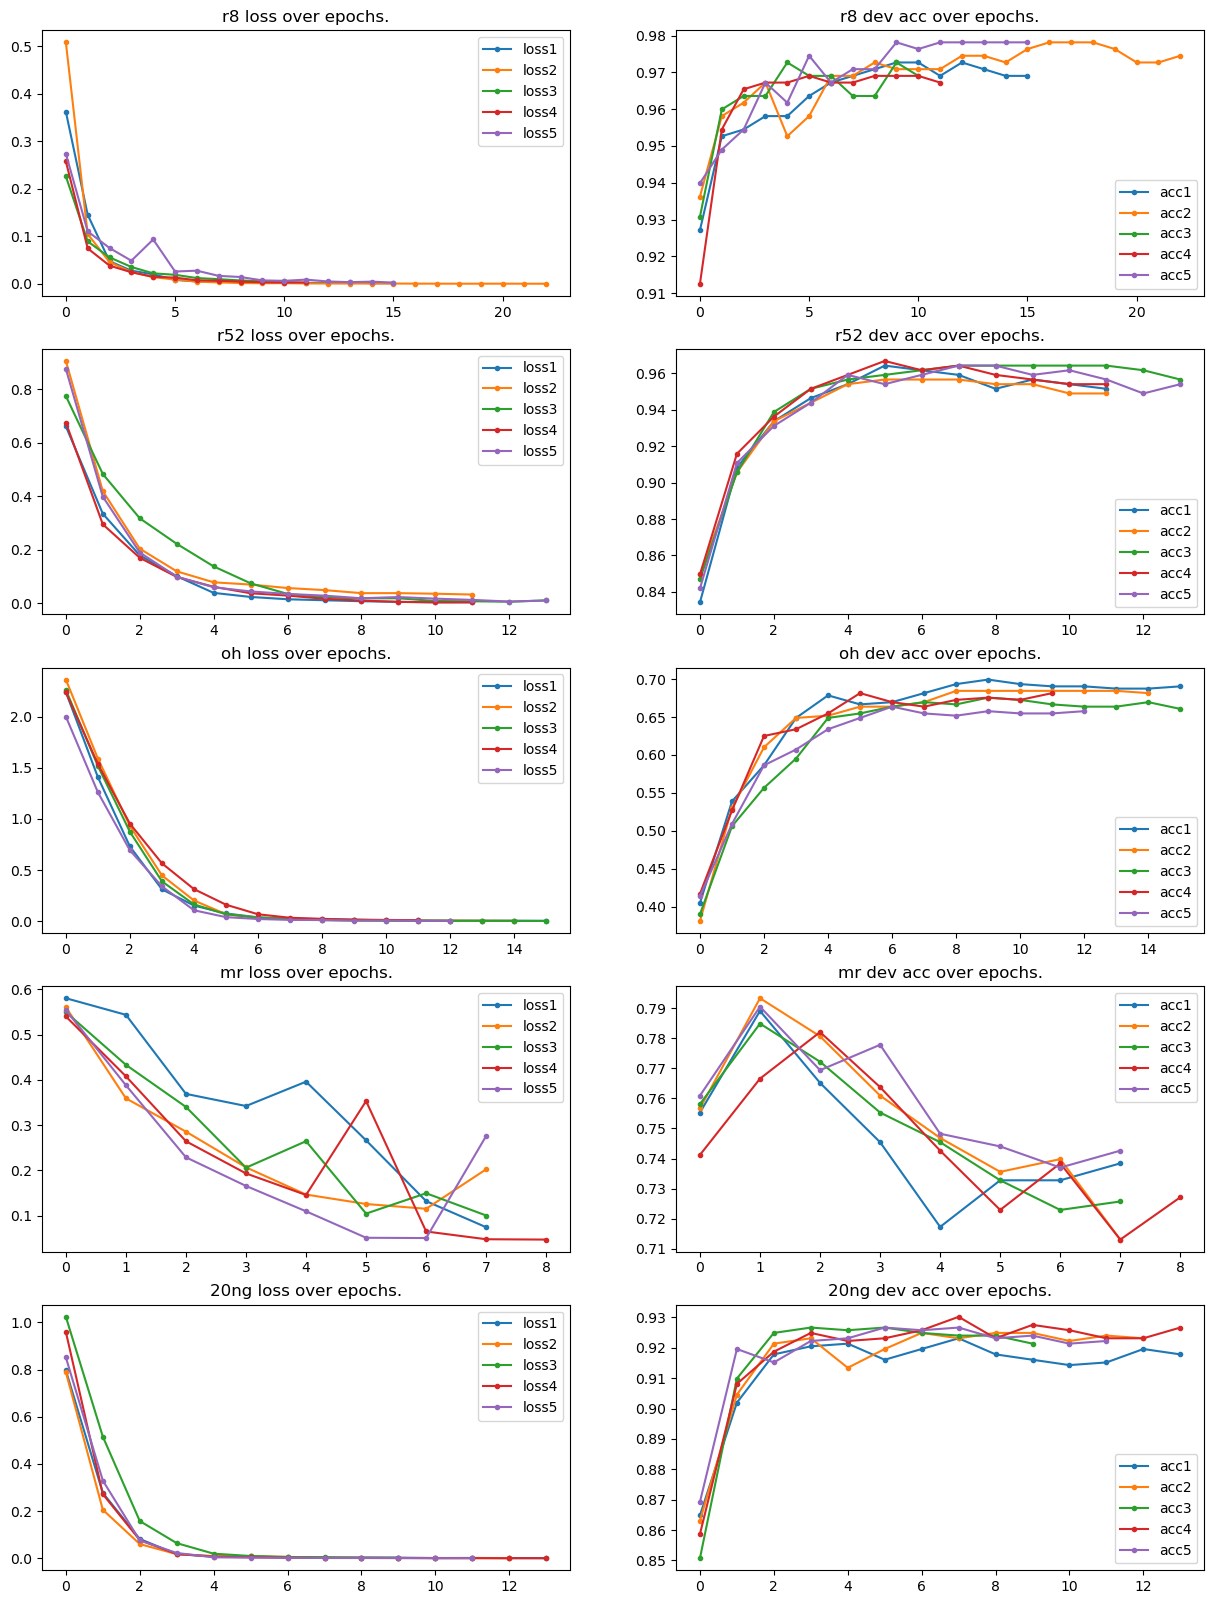

In [ ]:
def ReadAllResult(dataset_name):
  all_epoch, all_loss, all_dev_acc = [], [], []
  all_file = os.listdir(f"{COMMON_PATH}/TextLevelGNN/model/loss_acc")
  for t in all_file:
    if t.startswith(dataset_name):
      df = pd.read_csv(f"{COMMON_PATH}/TextLevelGNN/model/loss_acc/{t}")
      all_epoch.append(df["epoch"])
      all_loss.append(df["loss"])
      all_dev_acc.append(df["dev_acc"])
  
  return all_epoch, all_loss, all_dev_acc

# Loss, Dev Acc over epochs
fig = plt.figure(figsize=(15,20), dpi=100)
dataset_name = ["r8", "r52", "oh", "mr", "20ng"]

for index, name in enumerate(dataset_name):
  all_epoch, all_loss, all_dev_acc = ReadAllResult(name)
  ax2 = fig.add_subplot(5, 2, 2*index+1)
  for i in range(len(all_loss)):
    ax2.plot(all_epoch[i], all_loss[i], '.-', label=f"loss{i+1}")
  ax2.legend()
  plt.title(f"{name} loss over epochs.")

  ax3 = fig.add_subplot(5, 2, 2*index+2)
  for i in range(len(all_dev_acc)):
    ax3.plot(all_epoch[i], all_dev_acc[i], '.-', label=f"acc{i+1}")
  ax3.legend()
  plt.title(f"{name} dev acc over epochs.")

plt.show()

## Compare Baseline

Comparing with baseline methods.

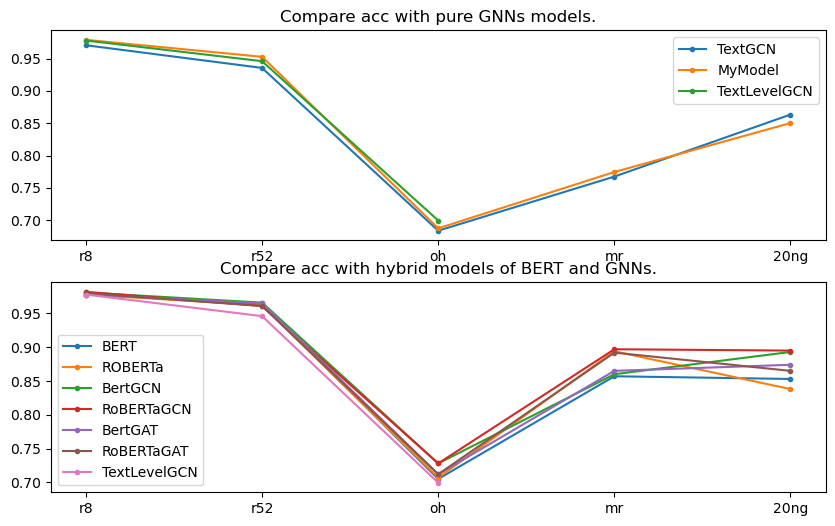

In [ ]:
# Baseline Method
TextGCN = [0.9707, 0.9356, 0.6836, 0.7674, 0.8634]
TextLevelGCN = [0.978, 0.946, 0.6994, None, None]
my_model_acc = [0.9791, 0.9528, 0.6873, 0.7745, 0.8503]


fig = plt.figure(figsize=(10,6),dpi=100)
ax1 = fig.add_subplot(211)
ax1.plot(dataset, TextGCN, '.-', label="TextGCN")
ax1.plot(dataset, my_model_acc, '.-', label="MyModel")
ax1.plot(dataset, TextLevelGCN, ".-", label="TextLevelGCN")
plt.title("Compare acc with pure GNNs models.")
ax1.legend()

# Baseline method
BERT = [0.978, 0.964, 0.705, 0.857, 0.853]
ROBERTa = [0.978, 0.962, 0.707, 0.894, 0.838]
BertGCN = [0.981, 0.966, 0.728, 0.860, 0.893]
RoBERTaGCN = [0.982, 0.961, 0.728, 0.897, 0.895]
BertGAT = [0.978, 0.965, 0.712, 0.865, 0.874]
RoBERTaGAT = [0.98, 0.961, 0.712, 0.892, 0.865]
ax2 = fig.add_subplot(212)
ax2.plot(dataset, BERT, '.-', label="BERT")
ax2.plot(dataset, ROBERTa, '.-', label="ROBERTa")
ax2.plot(dataset, BertGCN, '.-', label="BertGCN")
ax2.plot(dataset, RoBERTaGCN, '.-', label="RoBERTaGCN")
ax2.plot(dataset, BertGAT, '.-', label="BertGAT")
ax2.plot(dataset, RoBERTaGAT, '.-', label="RoBERTaGAT")
ax2.plot(dataset, TextLevelGCN, ".-", label="TextLevelGCN")
ax2.legend()
plt.title("Compare acc with hybrid models of BERT and GNNs.")

plt.show()

## Dataset Info

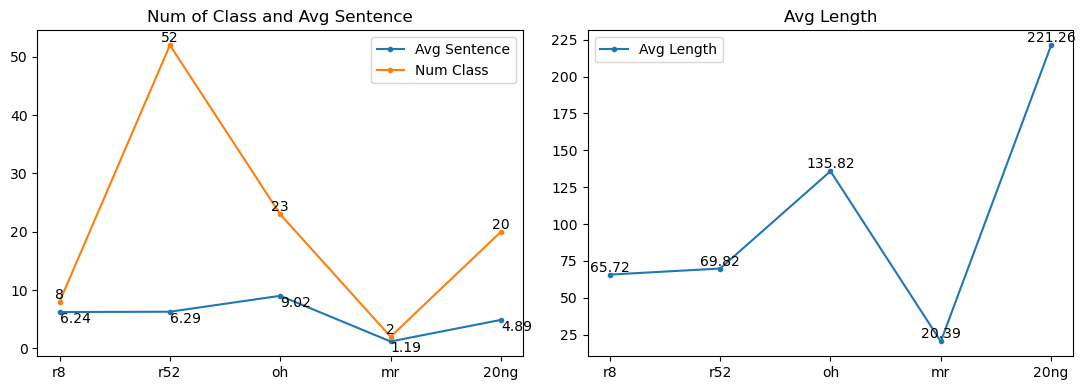

In [ ]:
fig = plt.figure(figsize=(11,4), layout="tight", dpi=100)
# Dataset Information
avg_sen = [6.24, 6.29, 9.02, 1.19, 4.89]
num_cla = [8, 52, 23, 2, 20]
ax1 = fig.add_subplot(121)
ax1.plot(dataset, avg_sen, '.-', label="Avg Sentence")
ax1.plot(dataset, num_cla, '.-', label="Num Class")
for a,b in zip(dataset, avg_sen):
  ax1.text(a, b, b, ha="left", va="top")
for a,b in zip(dataset, num_cla):
  ax1.text(a, b, b, ha="center", va="bottom")
plt.title("Num of Class and Avg Sentence")
ax1.legend()

avg_len = [65.72, 69.82, 135.82, 20.39, 221.26]
ax2 = fig.add_subplot(122)
ax2.plot(dataset, avg_len, '.-', label="Avg Length")
for a,b in zip(dataset, avg_len):
  ax2.text(a, b, b, ha="center", va="bottom")
ax2.legend()
plt.title("Avg Length")

plt.show()

# Miscellaneous: Debug

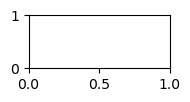

In [ ]:
a = [11,22,33]
fig = plt.figure(figsize=(4, 4), dpi=100)
#for i in range(10):
ax1 = fig.add_subplot(5,2,10)